In [32]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import glob
import pandas as pd
import warnings
pd.options.display.max_rows = 200
warnings.filterwarnings("ignore")
plt.style.use('seaborn-paper')

In [7]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [14]:
# Select Datasets and extract equivalent widths
spectrum = glob.glob("data/ew_known/tame_inputs/*wavsoln.fits")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'Spectrum File': spectrum, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)

lines = pd.read_csv(by_hand[0], header=None, delim_whitespace=True)[0].tolist()

In [29]:

width = 10 #Distance from the line on both sides to sample the local continuum from
gauss_amp = -0.2
gauss_width = 0.15
gauss_centhresh = 0.2

pars_dict={'7112.17':(10, -0.3, 0.15, 0.2)}

survey = []
for line in lines:
    percent_difference = True
    diff = []
    for row in disp_df.iterrows():
        eqw_file, spec_file = row[1]
        eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
        if line not in eqw_df[0].tolist():
            print("{} Line Missing: {}".format(spec_file,line))
            continue
        mask = eqw_df[0] == line
        byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
        if byhand_eqw == 0.:
            continue
    
        s_hdu = fits.open(spec_file)
    
        # Grab the flux and wavelength arrays from the spectrum
        s_data = s_hdu[1].data
        s_flux = s_data['FLUX']
        smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
        s_flux = smoothed_flux
        s_wav = s_data['WAVEL']

        # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
        lim_l = line - width
        lim_r = line + width

        # Mask the flux and wavelength arrays based on the sampled wavelength range
        wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
        s_flux = s_flux[wav_mask]
        s_wav = s_wav[wav_mask]

        # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
        yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
        # Load the normalized spectrum into a pyspeckit.Spectrum object
        sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

        #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
        sp.baseline.basespec = np.ones(len(s_wav))

        #Fit a gaussian to the line, this may be too simplistic for blended lines
        with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
            sp.specfit(fittype='gaussian', guesses = [gauss_amp, line, gauss_width], exclude= [0,line-gauss_centhresh, line+gauss_centhresh, line+5000])

        #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
        EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin = 0, xmax = len(norm))
        EQW = EQW*1000 #mA
        if percent_difference:
            ew_diff = ((EQW-byhand_eqw)/byhand_eqw) * 100 #Percent Difference
        else:
            ew_diff = EQW-byhand_eqw #mA Difference
        if ew_diff < 1000: #Try to cut out some of these crazy fits
            diff.append(ew_diff)
    if percent_difference:
        symbol = "%"
    else:
        symbol = " mA"
    line_stats = [line, np.median(diff),np.std(diff)]
    survey.append(line_stats)
    #print("{} Statistics".format(line))
    #print("===============")

    #print("Median Difference: {}{}".format(np.median(diff),symbol))
    #print("Standard Deviation of Difference: {}{}".format(np.std(diff), symbol))
    #print("~95% within {}{}".format(np.round(2*np.std(diff), 2), symbol))
    #print(" ")
survey_df = pd.DataFrame(survey, columns=["Line (Angstroms)", "Median Difference","Standard Deviation of Difference"])

### Performance Against Known EQWs

In [35]:
print("Difference Type: ",symbol)
survey_df

Difference Type:  %


,Line (Angstroms),Median Difference,Standard Deviation of Difference
0,5307.36,1.510530,2.525594
1,5322.04,4.547523,5.208532
2,5466.99,3.228912,5.783782
3,5491.83,-14.376587,15.828306
4,5522.45,5.759292,7.830292
5,5536.58,17.403138,22.660170
6,5539.28,6.598505,13.240460
7,5560.21,0.151126,5.367169
8,5577.03,-3.069408,14.288788
9,5607.66,-0.813986,10.274172


Difference Type:  %


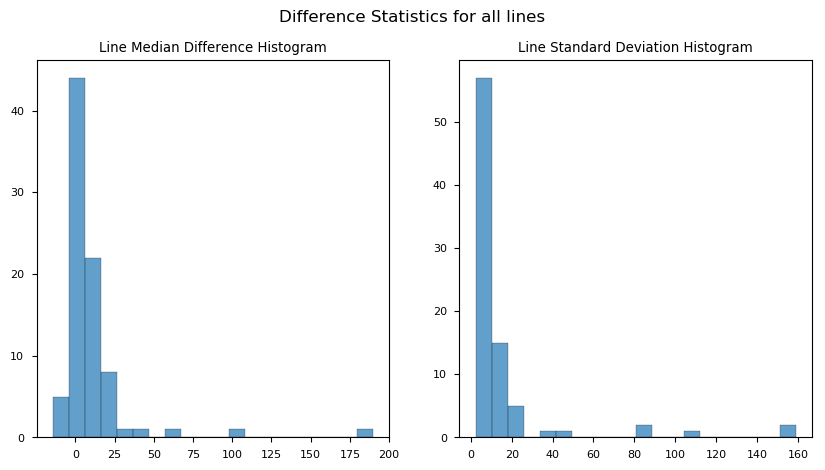

In [50]:
fig, axes = plt.subplots(1,2, figsize = (10,5), dpi = 100)
ax1,ax2 = axes
fig.suptitle("Difference Statistics for all lines")
ax1.hist(survey_df['Median Difference'],histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax1.set_title("Line Median Difference Histogram")
ax2.hist(survey_df['Standard Deviation of Difference'], histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax2.set_title("Line Standard Deviation Histogram")

print("Difference Type: ",symbol)

Difference Type:  %


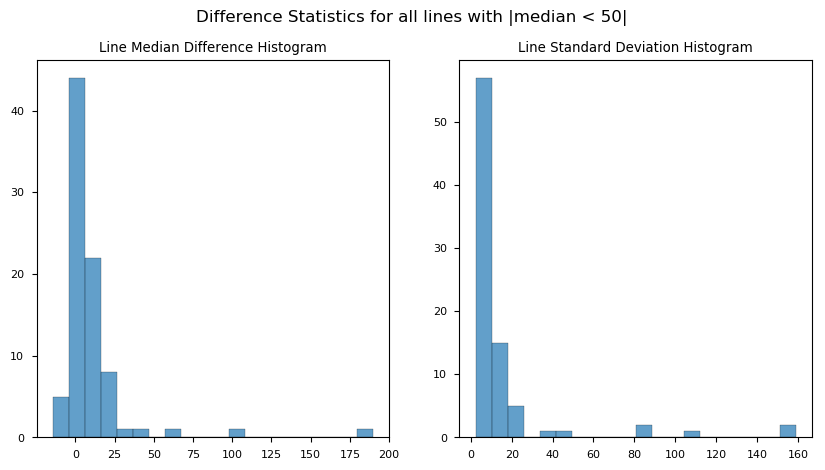

In [51]:
fig, axes = plt.subplots(1,2, figsize = (10,5), dpi = 100)
ax1,ax2 = axes
fig.suptitle("Difference Statistics for all lines with |median < 50|")
ax1.hist(survey_df['Median Difference'],histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax1.set_title("Line Median Difference Histogram")
ax2.hist(survey_df['Standard Deviation of Difference'], histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax2.set_title("Line Standard Deviation Histogram")

print("Difference Type: ",symbol)